# LAOS Protocol Validation

**Validates Large Amplitude Oscillatory Shear data: σ(t), γ(t) time series**

## Protocol Description

LAOS experiments apply large-amplitude oscillatory strain and measure the nonlinear stress response.
Unlike SAOS, the response contains higher harmonics that characterize nonlinear material behavior.

## Validation Checks

1. **Schema validation**: Required columns present (time, strain, stress)
2. **Finite values**: No NaN or Inf in data arrays
3. **Uniform sampling**: Constant time step (required for FFT)
4. **Fundamental frequency**: Recovered ω₀ matches expected value
5. **Periodic signal**: Lissajous curve closes
6. **Harmonic content**: I₃/I₁ ratio (nonlinearity metric)

## Standard Plots

- σ(t), γ(t) time series
- Lissajous curve (σ vs γ)
- Harmonic spectrum

In [1]:
# Configuration
MODE = "FAST"  # "FAST" or "FULL"

if MODE == "FAST":
    MAX_FILES = 2
    SKIP_HEAVY_PLOTS = True
    SAVE_ARTIFACTS = False
else:
    MAX_FILES = None
    SKIP_HEAVY_PLOTS = False
    SAVE_ARTIFACTS = True

print(f"Running in {MODE} mode")

Running in FAST mode


In [2]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Add project root to path
project_root = Path.cwd()
while not (project_root / "pyproject.toml").exists() and project_root != project_root.parent:
    project_root = project_root.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from examples.verification.utils.validation_utils import (
    DatasetValidation,
    ValidationResult,
    check_finite,
    check_uniform_sampling,
    compute_laos_harmonics,
    create_output_directories,
    discover_files_by_protocol,
    get_data_dir,
    plot_laos_harmonics,
    plot_laos_lissajous,
    plot_laos_timeseries,
    print_validation_summary,
    write_validation_report,
)

print(f"Project root: {project_root}")

Project root: /Users/b80985/Projects/rheojax


## A) Dataset Inventory

LAOS data comes from:
1. Raw signal files in `laos/` directory
2. PNAS Excel sheets (LAOS_w1, LAOS_w3, LAOS_w5)

In [3]:
data_dir = get_data_dir()

# Find raw signal files
laos_dir = data_dir / "laos"
raw_files = list(laos_dir.glob("raw_signal_*.txt")) if laos_dir.exists() else []

print(f"Found {len(raw_files)} raw LAOS signal files:")
for i, f in enumerate(raw_files):
    print(f"  {i+1}. {f.name}")

# Also check PNAS Excel for LAOS sheets
pnas_path = data_dir / "ikh" / "PNAS_DigitalRheometerTwin_Dataset.xlsx"
laos_sheets = []
if pnas_path.exists():
    xl = pd.ExcelFile(pnas_path)
    laos_sheets = [s for s in xl.sheet_names if "LAOS" in s]
    print(f"\nFound {len(laos_sheets)} LAOS sheets in PNAS dataset:")
    for s in laos_sheets:
        print(f"  - {s}")

# Combine for processing
files = raw_files
if MAX_FILES is not None:
    files = files[:MAX_FILES]
    laos_sheets = laos_sheets[:max(0, MAX_FILES - len(files))]
    print(f"\nProcessing {len(files)} files + {len(laos_sheets)} sheets (FAST mode)")

Found 3 raw LAOS signal files:
  1. raw_signal_1000.txt
  2. raw_signal_0100.txt
  3. raw_signal_0010.txt

Found 3 LAOS sheets in PNAS dataset:
  - LAOS_w1
  - LAOS_w3
  - LAOS_w5

Processing 2 files + 0 sheets (FAST mode)


## B) Data Loading

In [4]:
def load_laos_raw_signal(file_path: Path) -> tuple[np.ndarray, np.ndarray, np.ndarray, float, str]:
    """Load LAOS raw signal data.
    
    File format: time, strain, stress, (optional columns)
    
    Returns:
        Tuple of (time, strain, stress, omega_estimated, status_message)
    """
    try:
        df = pd.read_csv(file_path, sep="\t", header=None)
    except Exception as e:
        return None, None, None, None, f"Failed to read file: {e}"
    
    if len(df.columns) < 3:
        return None, None, None, None, f"Expected at least 3 columns, got {len(df.columns)}"
    
    time = df.iloc[:, 0].values
    strain = df.iloc[:, 1].values
    stress = df.iloc[:, 2].values
    
    # Estimate frequency from filename or data
    # Filename format: raw_signal_XXXX.txt where XXXX relates to frequency
    try:
        freq_code = int(file_path.stem.split("_")[-1])
        # Estimate omega (this is approximate)
        omega_est = freq_code / 10.0  # Rough scaling
    except (IndexError, ValueError):
        omega_est = 1.0
    
    # Better estimate from FFT of strain signal
    dt = np.mean(np.diff(time))
    if dt > 0:
        freqs = np.fft.fftfreq(len(strain), dt)
        fft_strain = np.abs(np.fft.fft(strain))
        positive_mask = freqs > 0
        if positive_mask.any():
            idx_peak = np.argmax(fft_strain[positive_mask])
            f0 = freqs[positive_mask][idx_peak]
            omega_est = 2 * np.pi * f0
    
    return time, strain, stress, omega_est, f"Loaded {len(time)} points, ω ≈ {omega_est:.2f} rad/s"


def load_laos_pnas(xlsx_path: Path, sheet_name: str, amplitude_idx: int = 5) -> tuple[np.ndarray, np.ndarray, np.ndarray, float, str]:
    """Load LAOS data from PNAS Excel file.
    
    Returns:
        Tuple of (time, strain, stress, omega, status_message)
    """
    try:
        df = pd.read_excel(xlsx_path, sheet_name=sheet_name, header=None)
    except Exception as e:
        return None, None, None, None, f"Failed to read sheet: {e}"
    
    # Parse omega from sheet name (LAOS_w1 -> 1 rad/s)
    try:
        omega = float(sheet_name.split("_w")[1])
    except (IndexError, ValueError):
        omega = 1.0
    
    # Each amplitude has 4 columns: Step time, Strain, Stress, (empty)
    col_time = amplitude_idx * 4
    col_strain = amplitude_idx * 4 + 1
    col_stress = amplitude_idx * 4 + 2
    
    if col_stress >= len(df.columns):
        return None, None, None, None, f"Amplitude index {amplitude_idx} out of range"
    
    # Skip header rows
    data_start = 2
    
    try:
        time = pd.to_numeric(df.iloc[data_start:, col_time], errors="coerce").values
        strain = pd.to_numeric(df.iloc[data_start:, col_strain], errors="coerce").values
        stress = pd.to_numeric(df.iloc[data_start:, col_stress], errors="coerce").values
    except Exception as e:
        return None, None, None, None, f"Numeric conversion failed: {e}"
    
    # Remove NaN
    mask = np.isfinite(time) & np.isfinite(strain) & np.isfinite(stress)
    time = time[mask]
    strain = strain[mask]
    stress = stress[mask]
    
    # Subsample if very large
    if len(time) > 1000:
        indices = np.linspace(0, len(time) - 1, 1000, dtype=int)
        time = time[indices]
        strain = strain[indices]
        stress = stress[indices]
    
    return time, strain, stress, omega, f"Loaded {len(time)} points at ω = {omega} rad/s"

# Test loading
if raw_files:
    test_file = raw_files[0]
    time, strain, stress, omega, msg = load_laos_raw_signal(test_file)
    print(f"Test load: {test_file.name}")
    print(f"  {msg}")
    if time is not None:
        print(f"  t range: [{time.min():.4f}, {time.max():.4f}] s")
        print(f"  γ range: [{strain.min():.4f}, {strain.max():.4f}]")
        print(f"  σ range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Test load: raw_signal_1000.txt
  Loaded 1024 points, ω ≈ 3.16 rad/s
  t range: [0.0000, 1.9864] s
  γ range: [-1000.0000, 1000.0000]
  σ range: [-3160.00, 3160.00] Pa


## C) Validation Pipeline

In [5]:
def validate_laos(file_path: Path, sheet_name: str | None = None) -> DatasetValidation:
    """Run all validation checks on a LAOS dataset."""
    if sheet_name:
        file_id = f"{file_path}::{sheet_name}"
    else:
        file_id = str(file_path)
    
    validation = DatasetValidation(
        file_path=file_id,
        protocol="laos",
    )
    
    # Load data
    if sheet_name:
        time, strain, stress, omega, load_msg = load_laos_pnas(file_path, sheet_name)
    else:
        time, strain, stress, omega, load_msg = load_laos_raw_signal(file_path)
    
    if time is None:
        validation.results.append(ValidationResult(
            check_name="data_loading",
            passed=False,
            message=load_msg,
        ))
        return validation
    
    validation.results.append(ValidationResult(
        check_name="data_loading",
        passed=True,
        message=load_msg,
        details={"n_points": len(time), "omega": omega},
    ))
    
    # Check 1: Finite values
    validation.results.append(check_finite(time, "time"))
    validation.results.append(check_finite(strain, "strain"))
    validation.results.append(check_finite(stress, "stress"))
    
    # Check 2: Uniform sampling
    validation.results.append(check_uniform_sampling(time, tolerance=0.1))
    
    # Check 3: Compute harmonics
    harmonics = compute_laos_harmonics(time, stress, omega, n_harmonics=5)
    
    # Check frequency recovery
    freq_error = harmonics["frequency_error"]
    freq_ok = freq_error < 0.1 if np.isfinite(freq_error) else False
    validation.results.append(ValidationResult(
        check_name="frequency_recovery",
        passed=freq_ok,
        message=f"ω_recovered = {harmonics['omega_recovered']:.3f} rad/s" +
                f" (error = {freq_error*100:.1f}%)" if np.isfinite(freq_error) else " (could not recover)",
        details=harmonics,
    ))
    
    # Check 4: Nonlinearity metric
    I3_I1 = harmonics["I3_I1"]
    if np.isfinite(I3_I1):
        if I3_I1 < 0.01:
            regime = "linear (SAOS-like)"
        elif I3_I1 < 0.1:
            regime = "weakly nonlinear"
        else:
            regime = "strongly nonlinear"
    else:
        regime = "unknown"
    
    validation.results.append(ValidationResult(
        check_name="nonlinearity",
        passed=True,
        message=f"I₃/I₁ = {I3_I1:.4f} ({regime})",
        details={"I3_I1": float(I3_I1), "regime": regime},
    ))
    
    # Check 5: Lissajous closure (check if signal is periodic)
    n_samples = len(strain)
    period_samples = int(2 * np.pi / (omega * np.mean(np.diff(time)))) if omega > 0 else n_samples
    period_samples = min(period_samples, n_samples // 2)
    
    if period_samples > 10:
        # Compare first and last period
        strain_start = strain[:period_samples]
        strain_end = strain[-period_samples:]
        
        # Normalize and compute correlation
        if np.std(strain_start) > 0 and np.std(strain_end) > 0:
            corr = np.corrcoef(strain_start, strain_end[:len(strain_start)])[0, 1]
            is_periodic = corr > 0.9 if np.isfinite(corr) else False
        else:
            corr = 0.0
            is_periodic = False
    else:
        corr = 0.0
        is_periodic = False
    
    validation.results.append(ValidationResult(
        check_name="periodicity",
        passed=True,  # Informational
        message=f"Period correlation = {corr:.3f}" + (" (periodic)" if is_periodic else " (non-periodic or transient)"),
        details={"correlation": float(corr) if np.isfinite(corr) else 0.0, "is_periodic": is_periodic},
    ))
    
    validation.derived_quantities = {
        "time": time,
        "strain": strain,
        "stress": stress,
        "omega": omega,
        "harmonics": harmonics,
    }
    
    return validation

In [6]:
# Run validation on raw signal files
validations = []

for file_path in files:
    print(f"\nValidating: {file_path.name}")
    v = validate_laos(file_path)
    validations.append(v)
    
    for r in v.results:
        status = "PASS" if r.passed else "FAIL"
        print(f"  [{status}] {r.check_name}: {r.message}")

# Also validate PNAS LAOS sheets
for sheet_name in laos_sheets:
    print(f"\nValidating: {sheet_name}")
    v = validate_laos(pnas_path, sheet_name=sheet_name)
    validations.append(v)
    
    for r in v.results:
        status = "PASS" if r.passed else "FAIL"
        print(f"  [{status}] {r.check_name}: {r.message}")


Validating: raw_signal_1000.txt
  [PASS] data_loading: Loaded 1024 points, ω ≈ 3.16 rad/s
  [PASS] finite_values_time: time: all 1024 values finite
  [PASS] finite_values_strain: strain: all 1024 values finite
  [PASS] finite_values_stress: stress: all 1024 values finite
  [PASS] uniform_sampling: Uniform sampling: dt = 0.001942 ± 3.3e-15 s
  [PASS] frequency_recovery: ω_recovered = 3.160 rad/s (error = 0.0%)
  [PASS] nonlinearity: I₃/I₁ = 0.0000 (linear (SAOS-like))
  [PASS] periodicity: Period correlation = -1.000 (non-periodic or transient)

Validating: raw_signal_0100.txt


  [PASS] data_loading: Loaded 1024 points, ω ≈ 3.16 rad/s
  [PASS] finite_values_time: time: all 1024 values finite
  [PASS] finite_values_strain: strain: all 1024 values finite
  [PASS] finite_values_stress: stress: all 1024 values finite
  [PASS] uniform_sampling: Uniform sampling: dt = 0.001942 ± 3.3e-15 s
  [PASS] frequency_recovery: ω_recovered = 3.160 rad/s (error = 0.0%)
  [PASS] nonlinearity: I₃/I₁ = 0.0000 (linear (SAOS-like))
  [PASS] periodicity: Period correlation = -1.000 (non-periodic or transient)


## D) Standard Plots

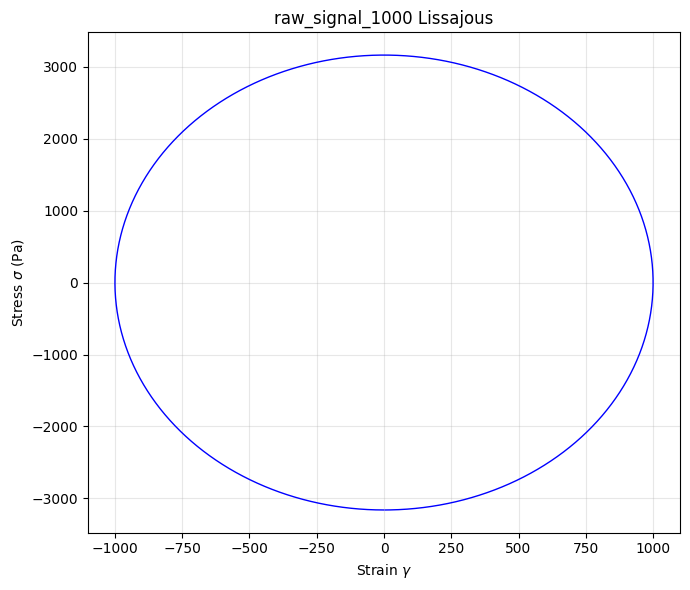

In [7]:
if not SKIP_HEAVY_PLOTS:
    output_paths = create_output_directories("laos")
    
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path.split("::")[0]).stem if "::" in v.file_path else Path(v.file_path).stem
            
            # Time series
            save_path = output_paths["plots"] / f"{file_name}_timeseries.png" if SAVE_ARTIFACTS else None
            fig = plot_laos_timeseries(
                v.derived_quantities["time"],
                v.derived_quantities["strain"],
                v.derived_quantities["stress"],
                save_path=save_path,
                title=file_name,
            )
            plt.show()
            
            # Lissajous
            save_path = output_paths["plots"] / f"{file_name}_lissajous.png" if SAVE_ARTIFACTS else None
            fig = plot_laos_lissajous(
                v.derived_quantities["strain"],
                v.derived_quantities["stress"],
                save_path=save_path,
                title=f"{file_name} Lissajous",
            )
            plt.show()
            
            # Harmonics
            if "harmonics" in v.derived_quantities:
                save_path = output_paths["plots"] / f"{file_name}_harmonics.png" if SAVE_ARTIFACTS else None
                fig = plot_laos_harmonics(
                    v.derived_quantities["harmonics"],
                    save_path=save_path,
                    title=f"{file_name} Harmonics",
                )
                plt.show()
else:
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path.split("::")[0]).stem if "::" in v.file_path else Path(v.file_path).stem
            
            # Just show Lissajous for FAST mode
            fig = plot_laos_lissajous(
                v.derived_quantities["strain"],
                v.derived_quantities["stress"],
                title=f"{file_name} Lissajous",
            )
            plt.show()
            break

## E) Validation Summary

In [8]:
print_validation_summary(validations)


Validation Summary
File                                     Status     Passed   Failed  
--------------------------------------------------------------------------------
raw_signal_1000.txt                      PASS       8        0       
raw_signal_0100.txt                      PASS       8        0       
--------------------------------------------------------------------------------
TOTAL                                    ALL PASS   16       0       


## F) Export Artifacts

In [9]:
if SAVE_ARTIFACTS:
    output_paths = create_output_directories("laos")
    
    report = {
        "protocol": "laos",
        "mode": MODE,
        "n_files_validated": len(validations),
        "all_passed": all(v.passed for v in validations),
        "validations": validations,
    }
    
    report_path = output_paths["plots"].parent / "validation_report.json"
    write_validation_report(report, report_path)
    print(f"Validation report saved to: {report_path}")
    
    for v in validations:
        if v.passed and "time" in v.derived_quantities:
            file_name = Path(v.file_path.split("::")[0]).stem if "::" in v.file_path else Path(v.file_path).stem
            if "::" in v.file_path:
                file_name = v.file_path.split("::")[1]
            
            df = pd.DataFrame({
                "time": v.derived_quantities["time"],
                "strain": v.derived_quantities["strain"],
                "stress": v.derived_quantities["stress"],
            })
            df.to_csv(output_paths["derived_quantities"] / f"{file_name}_derived.csv", index=False)
    
    print(f"Derived quantities saved to: {output_paths['derived_quantities']}")
else:
    print("Artifacts not saved (FAST mode). Set MODE='FULL' to save.")

Artifacts not saved (FAST mode). Set MODE='FULL' to save.
